# Pattern Recognition 2019 - 2020: Lab 2

#### Christos Lamprakos, 03002910

### Step 1
First, ```praat``` was installed according to the exercise description. Files ```onetwothree1.wav``` and ```onetwothree8.wav``` were then read with the program. Below the respective waveforms and spectrograms are illustrated, along with the pitches and the formants. Selections of phonemes were taken for the requested measurements.

![1](./figs/1_spec.png)
![2](./figs/2_spec.png)

The following data were then collected:

- onetwothree1.wav (male speaker, top figure)
    - 'a' 
        - pitch: 134.9 Hz
        - 1st formant: 712.36 Hz
        - 2nd formant: 1094.14Hz
        - 3rd formant: 2213.3 Hz
    - 'ou' 
        - pitch: 129.3 Hz
        - 1st formant: 400.5 Hz
        - 2nd formant: 1761.8 Hz
        - 3rd formant: 2353.4 Hz
    - 'ee'
        - pitch: 130.9 Hz
        - 1st formant: 402.9 Hz
        - 2nd formant: 1862.3 Hz
        - 3rd formant: 2294 Hz

- onetwothree8.wav (female speaker, bottom figure)
    - 'a' 
        - pitch: 179.9 Hz
        - 1st formant: 798.5 Hz
        - 2nd formant: 1416.9 Hz
        - 3rd formant: 2842 Hz
    - 'ou' 
        - pitch: 187.7 Hz
        - 1st formant: 332.8 Hz
        - 2nd formant: 1740.4 Hz
        - 3rd formant: 2683.2 Hz
    - 'ee'
        - pitch: 179.7 Hz
        - 1st formant: 400.7 Hz
        - 2nd formant: 2137 Hz
        - 3rd formant: 2792.4 Hz

> ***ATTENTION:*** Based on [this][tut] tutorial, the maximum formants for the male and female speakers were set to 5000 and 5500 Hz respectively.

The male speaker's pitch is lower than the female's for all vowels. This can also be deduced from the higher oscillation rate in the female speaker's waveform.

In most of the cases, the difference between the 2 speakers' formants increases with the formant index. The second and third formants of the female speaker are higher than their male counterparts.

The segments corresponding to each vowel were not picked with a systematic way. Both the pitch and the formants depend on calculations which with their turn depend on parameters that were not configured (in any other way than ```praat```'s any automatic process). Thus the results should be taken with a grain of salt.

>***HYPOTHESIS:*** A machine learning approach could leverage the data itself in order to resolve accuracy problems due to lack of expertise. Theoretical knowledge as regards pitch, formants etc. would then be of value only during the **interpretation**, not the **extraction** of the results.

### Rest Steps Preamble
For the rest of the steps, ```python``` was used. The code cell below includes all related imports. Data was read with ```librosa``` and represented with ```numpy``` arrays, ```pytplot``` was used for visualization. The custom-made ```ToolConfig``` class is of mostly typical nature:

```python
class ToolConfig ():
    def __init__ (self):
        self.one = './data/onetwothree1.wav'
        self.two = './data/onetwothree8.wav'
        self.digits_path = './data/digits'
```

[tut]: <https://www.gouskova.com/2016/09/03/praat-tutorial/#Annotating_an_audio_file_with_TextGrids>

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from config import ToolConfig
from src import tool, sklearn_classifiers, datautilus
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import NuSVC
from sklearn.neighbors import KNeighborsClassifier

conf = ToolConfig ()
sns.set ()

Last but not least, before anything else, a loading and plotting of the alreadyshown waveforms was done with ```librosa```, just to ensure that all works well.

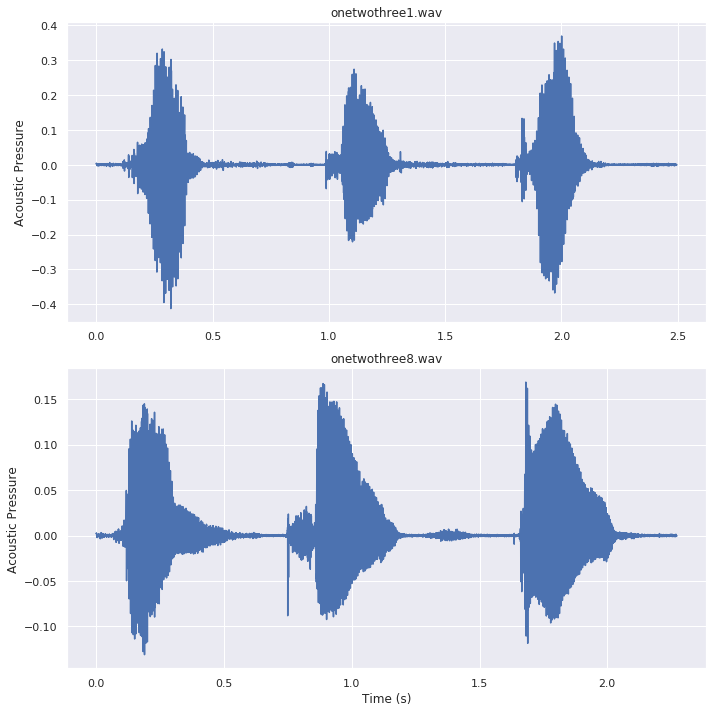

In [2]:
x, fr = librosa.load (conf.one)
x_time = np.linspace (0, (x.size - 1) / fr, x.size)
y, fr2 = librosa.load (conf.two)
y_time = np.linspace (0, (y.size - 1) / fr2, y.size)
fig = plt.figure (figsize = (10, 10))
ax1 = fig.add_subplot (211)
ax1.plot (x_time, x)
ax1.set_title ('onetwothree1.wav')
ax1.set_ylabel ('Acoustic Pressure')
ax2 = fig.add_subplot (212)
ax2.plot (y_time, y)
ax2.set_title ('onetwothree8.wav')
ax2.set_ylabel ('Acoustic Pressure')
ax2.set_xlabel ('Time (s)')
fig.tight_layout ()
plt.show ()

### Step 2
The following functions were implemented:

```python
def nameToFacts (fileName):
    """
    This function returns in int form the parsed results of sound
    files named like 'six2.wav'.
    """
    valText = fileName[:fileName.find ('.')]
    digIdx = valText.find ('1' or '2' or '3' or '4' or '5' or '6' \
                           or '7' or '8' or '9')
    digString = valText[:digIdx]
    speakNum = int (valText[digIdx:])
    return speakNum, {
                        'one' :     1,
                        'two' :     2,
                        'three' :   3,
                        'four' :    4,
                        'five' :    5,
                        'six' :     6,
                        'seven' :   7,
                        'eight' :   8,
                        'nine' :    9
                     }.get (digString)

def dataParser (path):
    """
    This function parses all files in the directory specified by
    the path input variable. It is assumed that all said files are
    valid .wav files.
    """
    waves = []
    rates = []
    digits = []
    speakers = []
    files = [f for f in listdir (path) if isfile (join (path, f))]
    for i in range (len (files)):
        #Keep both the signals themselves, and the sampling rates.
        sig, rate = librosa.load (join (path, files[i]))
        waves.append (sig)
        rates.append (rate)
        jspeak, jdig = nameToFacts (files [i])
        digits.append (jdig)
        speakers.append (jspeak)
    print ('Parsing complete! ', len (waves), ' files in total.')
    return waves, np.array (digits), np.array (speakers), rates
```

>All written functions are contained in the ```tool``` moodule of the ```src``` package submitted with this report

In [3]:
wavs, digits, speakers, rates = tool.dataParser (conf.digits_path)

Parsing complete!  133  files in total.


### Step 3

To compute the MFCC's, ```librosa.feature.mfcc``` was used. The important parameters here were ```sr``` (sampling rate), ```n_mfcc``` (number of features), ```win_length``` (length of window) and ```hop_length``` (overlap control).

Particularly as regards the overlap, ```hop_length``` controls the number of samples between adjacent Short Time Fourier Transforms of the signal. Thus, the requirements of the exercise description (window length, overlap) have to be translated in sample numbers.

Also,```librosa.feature.delta``` was used for the deltas.

All of the above were packed in the following function. Acting proactively, options for computing deltas and MFSC's instead of MFCC's were included:

```python
def featFactory (wavs, rates, win_sec = 25e-3, ov_sec = 10e-3, \
                 calc_deltas = True, mfsc = False):
    """
    This function extracts features from wavs. Rates are used to ensure proper
    calibration of the window and overlap parameters. By default, MFCC with
    deltas are calculated.
    """
    feats = []
    deltas = []
    deltas2 = []
    for i in range (len (wavs)):
        win = round (win_sec * rates[i])
        hop = round ((win_sec - ov_sec) * rates[i])
        if mfsc == False:
            feats.append (librosa.feature.mfcc (wavs[i], sr = rates[i],     \
                          #by default, librosa returns features as rows. We take
                          #the transpose to have them as columns.
                          n_mfcc = 13, win_length = win, hop_length = hop).T)
        else:             #melspectrogram is used to bypass the DCT performed by
                          #mfcc
            feats.append (librosa.feature.melspectrogram (wavs[i], sr = rates[i],
                          win_length = win, hop_length = hop, n_mels = 13).T)
        if calc_deltas:
            deltas.append (librosa.feature.delta (feats[i].T).T)
            deltas2.append (librosa.feature.delta (feats[i].T, order = 2).T)
    return feats, deltas, deltas2
```

In [4]:
feats, deltas, deltas2 = tool.featFactory (wavs, rates)

Now the features for all of the sound files are saved in the lists above. Note that on the one hand, using lists is not so efficient, but the different signal sizes do not leave us with a more flexible choice.

### Step 4
Due to the large number of figures, a wrapping function for the histogram plotting was written:

```python
def histPlotter (n1, feature, feats, digits, speakers):
    """
    This function draws the histograms of a certain feature of
    a certain digit across all speakers.
    """
    fig = plt.figure (figsize = (10, 10))
    fig_idx = 1
    sigslice = [feats[i][feature - 1, :] for i in range (len (feats)) if digits[i] == n1]
    speakslice = speakers[digits == n1]
    for i in range (len (sigslice)):
        ax = fig.add_subplot (4, 4, fig_idx)
        ax.hist (sigslice[i])
        ax.set_title ('Speaker ' + str (speakslice[i]))
        fig_idx += 1
    fig.tight_layout ()
    plt.show ()
```

>My student number is 03002910, which translates to n1 = 1, n2 = 2

The function was then called sequentially in order to provide the requested output. First, for the first feature of digit 1:


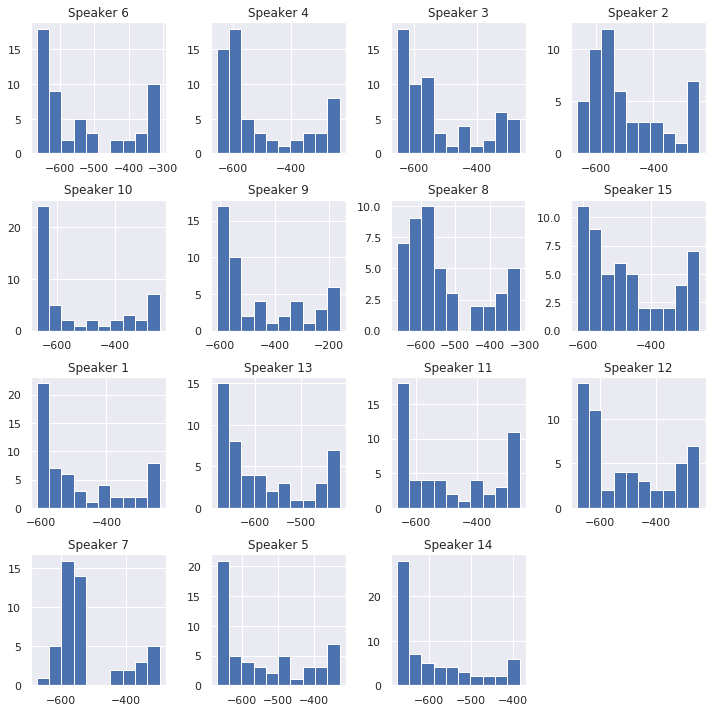

In [5]:
tool.histPlotter (1, 1, feats, digits, speakers)   

Then, for the second feature of digit 1:

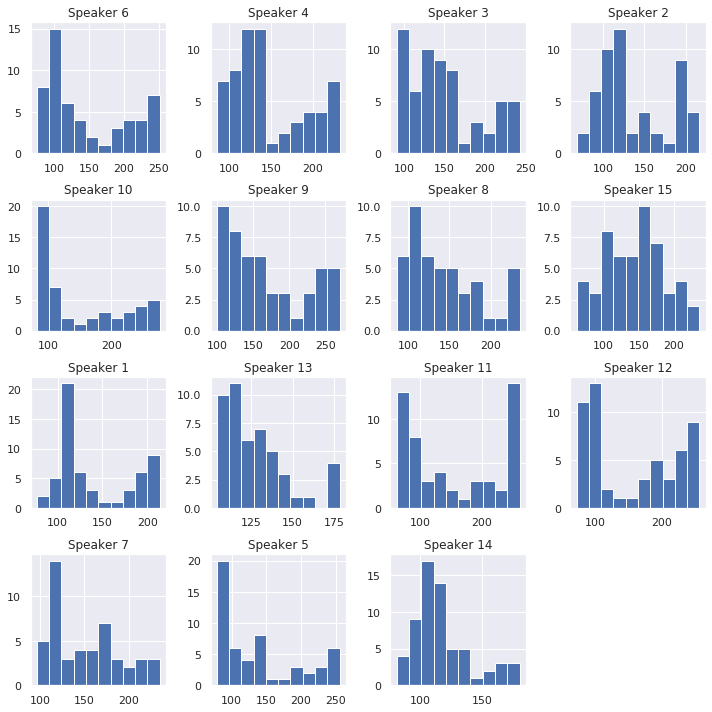

In [6]:
tool.histPlotter (1, 2, feats, digits, speakers) 

Then, for the first feature of digit 2:

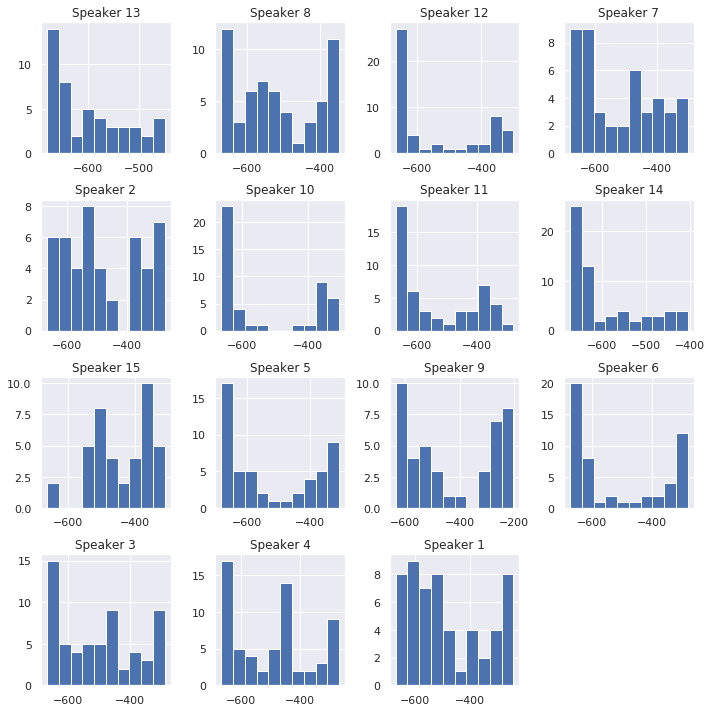

In [7]:
tool.histPlotter (2, 1, feats, digits, speakers) 

And finally, for 2's second feature:

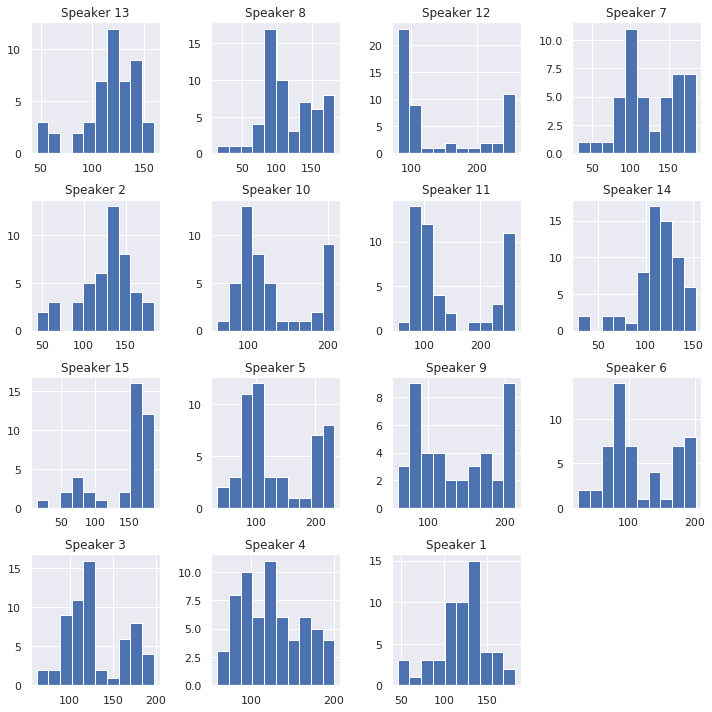

In [8]:
tool.histPlotter (2, 2, feats, digits, speakers) 

It would not be reasonable to call the information of these histograms useful or not, just by examining them with one's eyes. A stable result across all figures is that each feature has approximately the same range of values regardless of the speaker. Take the last cluster as an example, where all bins reside in a neighborhood largely defined by $[50, 200]$. A weaker observation is that of largely repeated peaks: in the same cluster, a neighborhood around value $100$ demonstrates a maximum frequency in most of the speakers.

Next, we have to compare MFCC's and MFSC's extracted on versions of $n_1$ and $n_2$ for 2 different speakers. We use the already presented ```featFactory``` function to compute the MFSC's. We then randomly choose 2 different speakers. Then, given the speakers and the digits of interest, we slice the corresponding features out.

```numpy.corrcoef``` was used for the heatmaps, since the features are **not** normalized at this point.

First random speaker:  1
Second random speaker:  14
Speakers OK! Exiting...


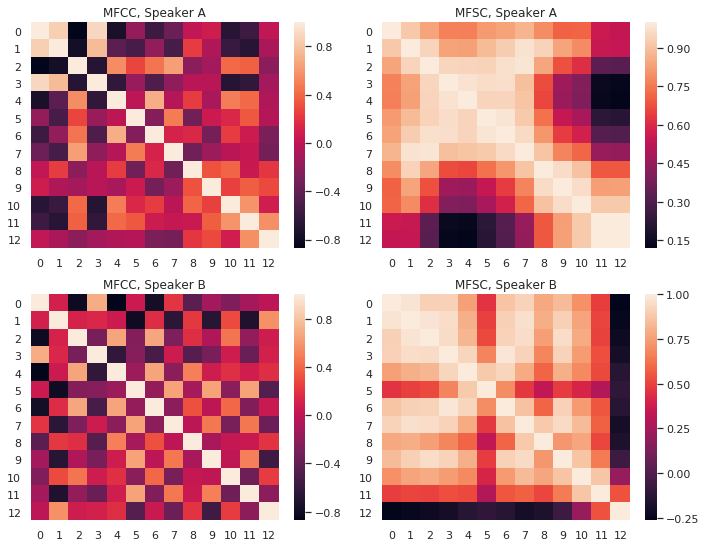

In [9]:
#Extract features...
mfsc_feats, d1, d2 = tool.featFactory (wavs, rates, mfsc = True)

#Pick 2 different speakers at random.
while True:
    speak_A = np.random.randint (1, 15)
    print ('First random speaker: ', speak_A)
    speak_B = np.random.randint (1, 15)
    print ('Second random speaker: ', speak_B)
    if speak_A != speak_B:
        print ('Speakers OK! Exiting...')
        break
    else:
        print ('Same speakers chosen! Trying again...')
        continue
        
#For each n1, n2 and for each speaker, slice out the corresponding feature series.
n1_A_mfcc = feats[np.where (speakers[digits == 1] == speak_A)[0][0]]
n1_A_mfsc = mfsc_feats[np.where (speakers[digits == 1] == speak_A)[0][0]]
n2_A_mfcc = feats[np.where (speakers[digits == 2] == speak_A)[0][0]]
n2_A_mfsc = mfsc_feats[np.where (speakers[digits == 2] == speak_A)[0][0]]
n1_B_mfcc = feats[np.where (speakers[digits == 1] == speak_B)[0][0]]
n1_B_mfsc = mfsc_feats[np.where (speakers[digits == 1] == speak_B)[0][0]]
n2_B_mfcc = feats[np.where (speakers[digits == 2] == speak_B)[0][0]]
n2_B_mfsc = mfsc_feats[np.where (speakers[digits == 2] == speak_B)[0][0]]

#Compute normalized covariance matrices for all the above:
n1Ac = np.corrcoef (n1_A_mfcc, rowvar = False)
n1As = np.corrcoef (n1_A_mfsc, rowvar = False)
n1Bc = np.corrcoef (n1_B_mfcc, rowvar = False)
n1Bs = np.corrcoef (n1_B_mfsc, rowvar = False)
n2Ac = np.corrcoef (n2_A_mfcc, rowvar = False)
n2As = np.corrcoef (n2_A_mfsc, rowvar = False)
n2Bc = np.corrcoef (n2_B_mfcc, rowvar = False)
n2Bs = np.corrcoef (n2_B_mfsc, rowvar = False)

fig = plt.figure (figsize = (10, 15))
ax1 = fig.add_subplot (4, 2, 1)
ax1 = sns.heatmap (n1Ac)
ax1.set_title ('MFCC, Speaker A')
ax2 = fig.add_subplot (4, 2, 2)
ax2 = sns.heatmap (n1As)
ax2.set_title ('MFSC, Speaker A')
ax1 = fig.add_subplot (4, 2, 3)
ax1 = sns.heatmap (n1Bc)
ax1.set_title ('MFCC, Speaker B')
ax2 = fig.add_subplot (4, 2, 4)
ax2 = sns.heatmap (n1Bs)
ax2.set_title ('MFSC, Speaker B')
fig.tight_layout ()
plt.show ()

The figures above are for $n_1$. Moving on to $n_2$:

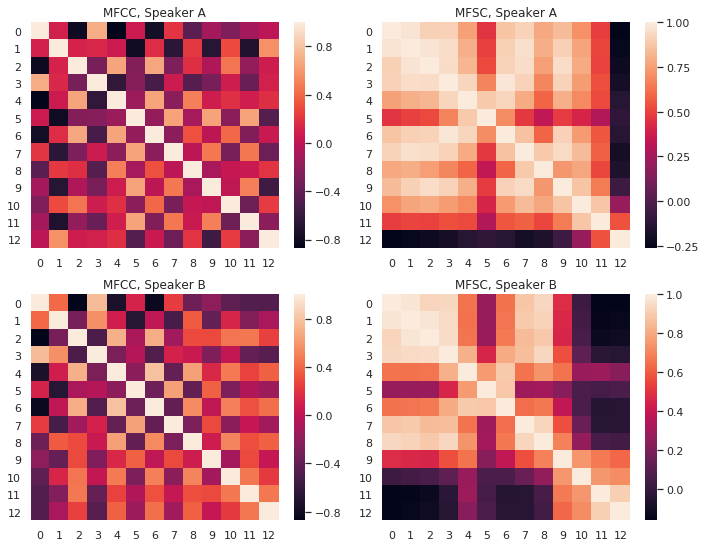

In [10]:
fig = plt.figure (figsize = (10, 15))
ax1 = fig.add_subplot (4, 2, 1)
ax1 = sns.heatmap (n2Ac)
ax1.set_title ('MFCC, Speaker A')
ax2 = fig.add_subplot (4, 2, 2)
ax2 = sns.heatmap (n2As)
ax2.set_title ('MFSC, Speaker A')
ax1 = fig.add_subplot (4, 2, 3)
ax1 = sns.heatmap (n2Bc)
ax1.set_title ('MFCC, Speaker B')
ax2 = fig.add_subplot (4, 2, 4)
ax2 = sns.heatmap (n2Bs)
ax2.set_title ('MFSC, Speaker B')
fig.tight_layout ()
plt.show ()

Based on the above, we deduce the following:
- MFSC features are quite unpredictable and correlated.
- MFCC features are more stable and independent.
    - thus from a pattern recognition perspective, MFCC's would achieve higher performance.
   
### Step 5
The following function was implemented in order to merge all requested features:

```python
def featCompression (feats, deltas, deltas2):
    """
    Returns augmented feature vectors for all cases.
    """
    feats_total = np.zeros (78)
    for i in range (len (feats)):
        row_total = np.array ([])
        feat_mean = np.mean (np.array (feats[i]), axis = 0)
        delt_mean = np.mean (np.array (deltas[i]), axis = 0)
        delt2_mean = np.mean (np.array (deltas2[i]), axis = 0)
        feat_std = np.std (np.array (feats[i]), axis = 0)
        delt_std = np.std (np.array (deltas[i]), axis = 0)
        delt2_std = np.std (np.array (deltas2[i]), axis = 0)
        row_total = np.hstack ((feat_mean, feat_std, delt_mean, delt_std, \
                                delt2_mean, delt2_std))
        feats_total = np.vstack ((feats_total, row_total))
    return feats_total[1:, :]
```
Below the features are generated through ```featCompression```. Then the requested scatter plots are plotted.

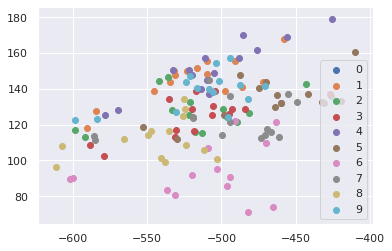

In [11]:
compFeats = tool.featCompression (feats, deltas, deltas2)
fig = plt.figure (figsize = (6, 4))
for i in range (10):
    plt.scatter (compFeats[digits == i][:, 0], compFeats[digits == i][:, 1], label = str (i))
plt.legend (loc = 'best')
plt.show ()

The above figure shows some very loose clustering of the 2 features, but also serious overlap between the 10 classes. This is expected, considering we are viewing mere mean values.

### Step 6
For PCA decomposition, ```scikit-learn``` is used. In the figures below, scatter plots for 2 and 3 final components are shown. A comparison between them and the previous scatter plot would be meaningless, since we were then looking at 'isolated' features that have, in this step, merged with the rest during the decomposition.

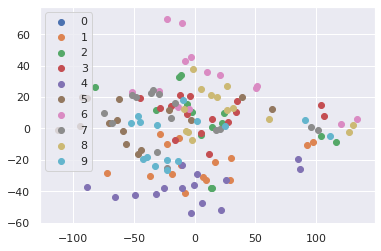

In [12]:
pca_obj = PCA (n_components = 2)
X = pca_obj.fit_transform (compFeats)
fig = plt.figure (figsize = (6, 4))
for i in range (10):
    plt.scatter (X[digits == i][:, 0], X[digits == i][:, 1], label = str (i))
plt.legend (loc = 'best')
plt.show ()

A loose-but-inconclusive clustering can also be observed in the above figure. As for the figure below, it **could** contribute in separating the clusters in horizontal planes, but only with testing would a meaningful discussion be feasible. 

>Still, PCA of statistically aggregated spectral features seems extremely weak for a speech recognition task.

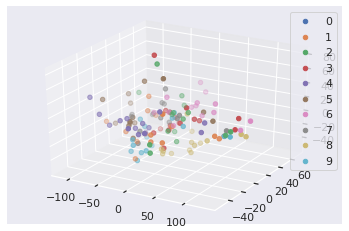

In [13]:
pca_obj_2 = PCA (n_components = 3)
Y = pca_obj_2.fit_transform (compFeats)
fig = plt.figure (figsize = (6, 4))
ax = fig.add_subplot (111, projection = '3d')
for i in range (10):
    ax.scatter (Y[digits == i][:, 0], Y[digits == i][:, 1], Y[digits == i][:, 2], label = str (i))
plt.legend (loc = 'best')
plt.show ()

As regards the new variances, we print the explained variance ratios of the 2 decompositions. We see that in the first case, the components explain ~70% of the total variance, while in the second case the percentage increases at ~80%. Consequently, if a classifier used the decomposed representations, it would miss out on a substantial amount of information.

In [14]:
print (pca_obj.explained_variance_ratio_)
print (pca_obj_2.explained_variance_ratio_)

[0.58210541 0.12074877]
[0.58210541 0.12074877 0.10961696]


### Step 7
A preprocessing step is performed for data standardization. Then scikit-learn's ```train_test_split``` is used for creating a training and a test batch. After that, we perform 10-fold cross validation on:
- Lab 1's Naive Bayes classifier
- sklearn's Naive Bayes implementation
- Lab 1's euclidean classifier
- an SVM with RBF kernel
- a 3 nearest neighbors classifier

In [15]:
scaler = StandardScaler ()
scaledFeats = scaler.fit_transform (compFeats)

X_train, X_test, y_train, y_test = train_test_split (scaledFeats, digits, test_size = 0.3)

customB = sklearn_classifiers.NaiveBayesClassifier ()
scoreB = cross_validate (customB, compFeats, digits, cv = 5)
print ('Lab 1 Bayesian Classifier scored', 100 * np.mean (scoreB['test_score']), '% in 10-fold cross-calidation.')

vanillaB = GaussianNB ()
scoreVB = cross_validate (vanillaB, compFeats, digits, cv = 5)
print ('sklearn Bayesian Classifier scored', 100 * np.mean (scoreVB['test_score']), '% in 10-fold cross-calidation.')

euclid = sklearn_classifiers.EuclideanClassifier ()
scoreEC = cross_validate (euclid, compFeats, digits, cv = 5)
print ('Lab 1 Euclidean Classifier scored', 100 * np.mean (scoreEC['test_score']), '% in 10-fold cross-calidation.')

svm = NuSVC (kernel = 'rbf', gamma = 'scale')
scoreSVM = cross_validate (svm, compFeats, digits, cv = 5)
print ('RBF SVM scored', 100 * np.mean (scoreSVM['test_score']), '% in 10-fold cross-calidation.')

neighbors = KNeighborsClassifier (n_neighbors = 3, algorithm = 'ball_tree')
scoreNN = cross_validate (neighbors, compFeats, digits, cv = 5)
print ('3-NN scored', 100 * np.mean (scoreNN['test_score']), '% in 10-fold cross-calidation.')

Lab 1 Bayesian Classifier scored 63.911111111111104 % in 10-fold cross-calidation.
sklearn Bayesian Classifier scored 63.911111111111104 % in 10-fold cross-calidation.
Lab 1 Euclidean Classifier scored 50.39999999999999 % in 10-fold cross-calidation.
RBF SVM scored 72.35555555555555 % in 10-fold cross-calidation.
3-NN scored 51.318518518518516 % in 10-fold cross-calidation.


The SVM proves to achieve the highest performance on the task. The 2 Bayesian classifiers achieve the same performance, as was expected. The 3 nearest neighbors and the euclidean classifier perform very closely, indicating that the data are indeed clustered through the selected features (but the clustering is correct only half of the time).

## Step 8
We will randomly generate 100 sequences of sines and cosines. Since both of the signals have frequency $f = 40 Hz$, they also have period $T = {1 \over 40} s$. That is, after randomly picking a starting point $t_s$ in the $[0, T]$ range, we match it with an ending point $t_e = t_s + T = t_s + {1 \over 40} s$. All this is done by the following function:

```python
def sinData (f, N, points, P):
    """
    Returns N input-output pairs of points-length sines and cosines of frequency
    f. The signals span P multiples of their periods.
    """
    #Compute oscillation periods.
    T = 1 / f
    #Generate N random starting points.
    start = np.random.rand (N) * T
    #Compute sines and cosines in all intervals.
    s_data = np.array ([])
    c_data = np.array ([])
    for i in range (N):
        s_slice = np.sin (2 * np.pi * f * np.linspace (start[i],        \
                  start[i] + P * T, points))
        c_slice = np.cos (2 * np.pi * f * np.linspace (start[i],        \
                  start[i] + P * T, points))
        if i == 0:
            s_data = s_slice
            c_data = c_slice
        else:
            s_data = np.vstack ((s_data, s_slice))
            c_data = np.vstack ((c_data, c_slice))
    return s_data, c_data
```
Below the sequences are generated and a randomly chosen pair is plotted.

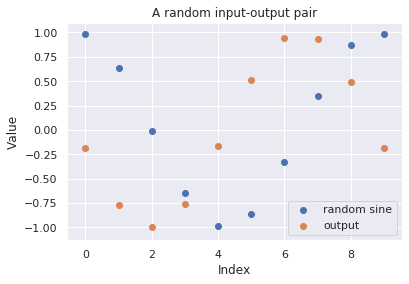

In [22]:
X, y = tool.sinData (40, 100, 10, 1)
t = np.arange (10)
idx = np.random.randint (0, 100)
fig = plt.figure ()
plt.scatter (t, X[idx, :], label = 'random sine')
plt.scatter (t, y[idx, :], label = 'output')
plt.xlabel ('Index')
plt.ylabel ('Value')
plt.title ('A random input-output pair')
plt.legend (loc = 'best')
plt.show ()

Do we need all created sequences for training our network? Certainly the ideal outcome would be to generate arbitrary-length cosines with arbitrary-length sines as input. Our choice of sampling the signals in intervals equal with their period ensures that all the required information is captured. Well, just for the sake of a beginner's curiosity, we will first attempt to achieve the ideal outcome with only one sequence.

So let's create and train an RNN using ```pytorch```.

In [32]:
import torch

In [129]:
class dummyRNN (torch.nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=10, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = torch.nn.RNN(input_size, hidden_layer_size)
        self.linear = torch.nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = torch.zeros(1, 1, self.hidden_layer_size)
                            #torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.rnn(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [130]:
lazarus = dummyRNN ()

In [136]:
lazarus.forward (torch.randn(10, 1).view (10, 1, -1))

tensor([0.2612], grad_fn=<SelectBackward>)